This is notebook with Convolutional Autoencoder and Data visulaization

In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
import nltk
nltk.download('punkt')
import numpy as np
import pandas as pd

C:\Users\aishw\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aishw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Input - input Image of 200* 200* 1 dimensions. 
encoder is a stack of Conv2D and MaxPooling2D, Decoder is stack of Conv2D and UpSampling2D

In [2]:
input_img = Input(shape=(200, 200, 1)) 

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((10, 10), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((10, 10), padding='same')(x)
x = Conv2D(8, (3, 3), activation='linear', padding='same')(x)
encoded = MaxPooling2D((1, 1), padding='same')(x)

In [3]:
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((10, 10))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((10, 10))(x)
decoded = Conv2D(1, (3, 3), activation='relu')(x)
x = UpSampling2D((1, 1))(x)
decoded = Conv2D(1, (3, 3), activation='linear', padding='same')(x)

In [ ]:
Defining Model 

In [4]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

File of 1096 dimnesion and glove of 50 Dimensions.

In [5]:
df = pd.read_csv("data_v2_1096.csv", encoding="utf8")
docs = []
labels = []
#iterate over every row of the dataframe
for index,row in df.iterrows():
  docs.append(row["sent_text"])
  labels.append(row["rule_total"])
fn = 'glove.6B.200d.txt'
f = open(fn, encoding="utf8")
embeddings_index = dict()
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs

x_train = np.zeros((index+1,40000));
sntidx = 0
for sent in docs:
  tok = nltk.word_tokenize(sent.lower())
  asent = np.zeros((200,200))
  wrds = 0
  for token in tok:
    if token in embeddings_index:
      asent[wrds] = embeddings_index[token]
      wrds += 1
      if wrds == 200:
        break
  #print asent
  x_train[sntidx] = asent.flatten()
  sntidx += 1
x_test = x_train[50:200]
print(x_train.shape)
print(x_test.shape)

(1096, 40000)
(150, 40000)


In [6]:
x_train = np.reshape(x_train, (len(x_train), 200, 200, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 200, 200, 1))  
print(x_train.shape)
print(x_test.shape)

(1096, 200, 200, 1)
(150, 200, 200, 1)


training model for 150 epochs

In [7]:
autoencoder.fit(x_train, x_train,
                epochs=150,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 1096 samples, validate on 150 samples
Epoch 1/150
1096/1096 [==============================] - 108s 98ms/step - loss: 0.0511 - val_loss: 0.0549
Epoch 2/150
1096/1096 [==============================] - 104s 95ms/step - loss: 0.0424 - val_loss: 0.0265
Epoch 3/150
1096/1096 [==============================] - 104s 95ms/step - loss: 0.0245 - val_loss: 0.0256
Epoch 4/150
1096/1096 [==============================] - 101s 92ms/step - loss: 0.0216 - val_loss: 0.0222
Epoch 5/150
1096/1096 [==============================] - 104s 95ms/step - loss: 0.0256 - val_loss: 0.0231
Epoch 6/150
1096/1096 [==============================] - 104s 95ms/step - loss: 0.0217 - val_loss: 0.0231
Epoch 7/150
1096/1096 [==============================] - 109s 100ms/step - loss: 0.0211 - val_loss: 0.0235
Epoch 8/150
1096/1096 [==============================] - 105s 96ms/step - loss: 0.0216 - val_loss: 0.0220
Epoch 9/150
1096/1096 [==============================] - 104s 95ms/step - loss: 0.0205 - val_loss: 0.022

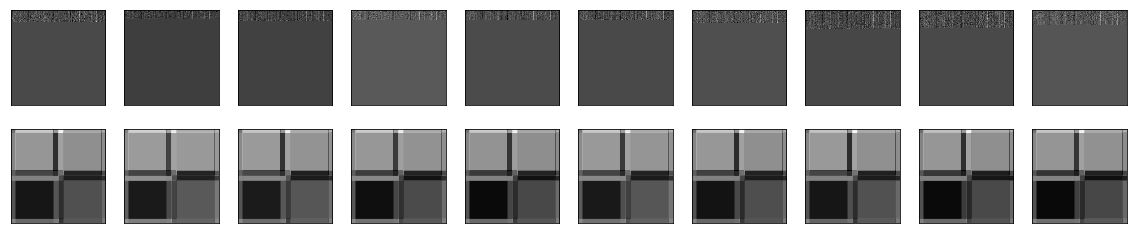

In [8]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n,i+1)
    plt.imshow(x_test[i].reshape(200, 200))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(200, 200))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig('cae.png', dpi=350)
plt.show()